In [31]:
import numpy as np
import pandas as pd
df = pd.read_parquet("/home/s193881/Industrial-IoT-For-Digitization-Of-Electronic-Assets-Course/Final Project/data/pump_station_data.parquet")
df = df[:40000]
df = df[['height', 'outflow']]

inflow = np.zeros(len(df))

df.insert(2, "inflow", inflow, True)

In [32]:
from filterpy.kalman import KalmanFilter
t = 1
area = 18
initial_Qin = df['outflow'].iloc[0]
initial_Qout = df['outflow'].iloc[0]
initial_h = df['height'].iloc[0]

# Process / Estimation Errors
error_est_Qin = 0.01
error_est_h = 0.01
error_est_Qout = 0.01

error_obs_h = 0.001
error_obs_Qout = 0.001

# Define the state transition matrix (A)
A = np.array([[1, 0, 0], [t/area, 1, -t/area], [0, 0, 1]])

# Create a Kalman Filter instance, where dim_x is the state dimension, dim_z is the measurement dimension
kf = KalmanFilter(dim_x=3, dim_z=2) 

# Initialize the state (x) and covariance (P) matrices
kf.x = np.array([initial_Qin, initial_h, initial_Qout]) # Initial state
#kf.P *= 2 # Initial covariance, you can customize this

# Define the state transition (F) and observation (H) matrices
kf.F = A
kf.H = np.array([[0, 1, 0], [0, 0, 1]]) # Assuming you are observing h and Qout

In [33]:
from tqdm import tqdm

# Store estimates
estimates = []

# Initialize tqdm with the total number of iterations (total rows in df)
progress_bar = tqdm(total=len(df), desc="Processing")

for index, row in df.iterrows():
    kf.predict()
    measurement = np.array([row['height'], row['outflow']])
    kf.update(measurement)
    estimates.append(kf.x.copy())
    progress_bar.update(1)  # Update the progress bar

progress_bar.close()  # Close the progress bar when done
estimates = np.array(estimates)

Processing: 100%|██████████| 40000/40000 [00:13<00:00, 3017.86it/s]


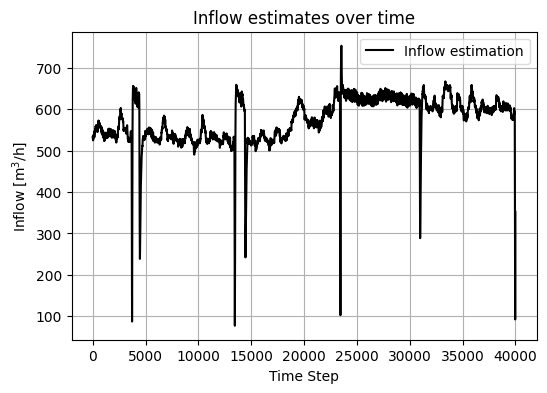

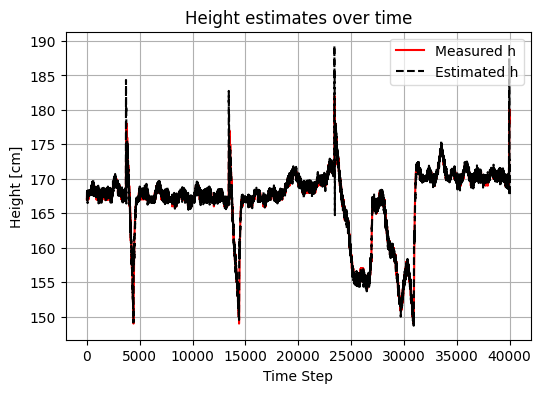

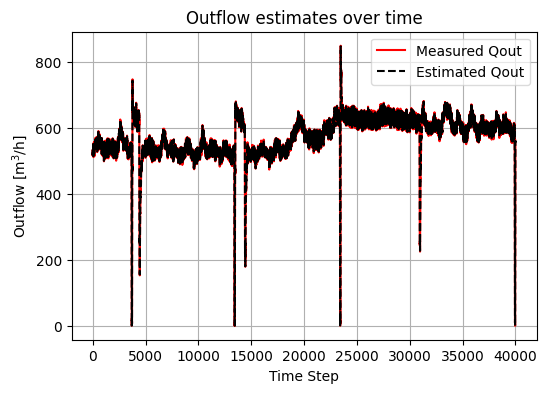

In [34]:
import matplotlib.pyplot as plt

# Convert estimates to a numpy array for easier manipulation
estimates = np.array(estimates)

# Time steps for x-axis
time_steps = range(len(estimates))

fig_size = (6, 4)

# Plot for Qin
plt.figure(figsize=fig_size)
plt.plot(time_steps, estimates[:, 0], label='Inflow estimation', color="black", linestyle='-')
plt.xlabel('Time Step')
plt.ylabel('Inflow [m$^3$/h]')
plt.title('Inflow estimates over time')
plt.grid()
plt.legend(loc='upper right', fancybox=True, framealpha=0.7)
plt.show()

# Plot for h
plt.figure(figsize=fig_size)
plt.plot(time_steps, df["height"], label='Measured h', color="red", linestyle='-')
plt.plot(time_steps, estimates[:, 1], label='Estimated h', color="black", linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Height [cm]')
plt.title('Height estimates over time')
plt.grid()
plt.legend(loc='upper right', fancybox=True, framealpha=0.7)
plt.show()

# Plot for Qout
plt.figure(figsize=fig_size)
plt.plot(time_steps, df["outflow"], label='Measured Qout', color="red", linestyle='-')
plt.plot(time_steps, estimates[:, 2], label='Estimated Qout', color="black", linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Outflow [m$^3$/h]')
plt.title('Outflow estimates over time')
plt.grid()
plt.legend(loc='upper right', fancybox=True, framealpha=0.7)
plt.show()

In [15]:
inflow_data = pd.DataFrame(estimates[:,0])

In [16]:
inflow_data.to_csv("/home/s193881/Industrial-IoT-For-Digitization-Of-Electronic-Assets-Course/Final Project/InflowData.csv")

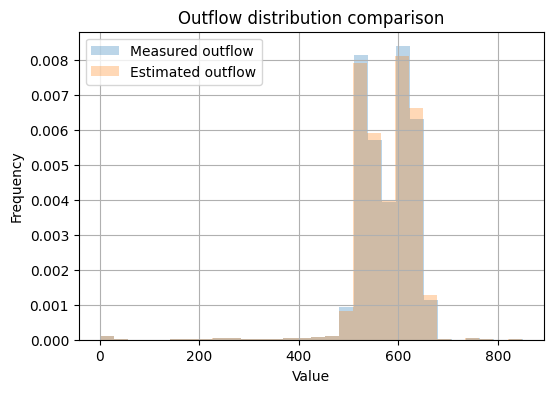

The KL Divergence is: 0.0012


In [19]:
from scipy.stats import entropy

# Generating two sample distributions
data1 = df["outflow"]  # Normal distribution 1
data2 = estimates[:, 2]

# Creating histograms for the distributions
count1, bins1 = np.histogram(data1, bins=30, density=True)
count2, bins2 = np.histogram(data2, bins=30, density=True)

# Calculating the bin centers from the bin edges
bin_centers1 = (bins1[1:] + bins1[:-1]) / 2
bin_centers2 = (bins2[1:] + bins2[:-1]) / 2

# Plotting the histograms
plt.figure(figsize=(6, 4))
plt.hist(data1, bins=30, alpha=0.3, label='Measured outflow', density=True)
plt.hist(data2, bins=30, alpha=0.3, label='Estimated outflow', density=True)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Outflow distribution comparison')
plt.grid()
plt.legend()

# Calculating Kullback-Leibler Divergence


plt.show()
kl_divergence = entropy(count1, count2)
print(f"The KL Divergence is: {kl_divergence:.4f}")

In [20]:
from tqdm import tqdm

def remove_outliers(df, column_name, window_size=150, lower_quantile=0.4, upper_quantile=0.6, threshold=1.5):
    """
    Remove outliers from a DataFrame column based on rolling window IQR method.

    Args:
    df (pd.DataFrame): DataFrame containing the data.
    column_name (str): Name of the column to process.
    window_size (int): Size of the rolling window.
    lower_quantile (float): Lower quantile for IQR calculation.
    upper_quantile (float): Upper quantile for IQR calculation.
    threshold (float): Threshold multiplier for IQR.

    Returns:
    pd.DataFrame: DataFrame with outliers removed.
    """

    # Function to detect outliers in a series
    def detect_outliers(series):
        Q1 = series.quantile(lower_quantile)
        Q3 = series.quantile(upper_quantile)
        IQR = Q3 - Q1
        return ~((series < (Q1 - threshold * IQR)) | (series > (Q3 + threshold * IQR)))

    # Initialize an empty Series to store the outlier mask
    outlier_mask = pd.Series([False] * len(df), index=df.index)

    # Iterate over the rolling windows
    for start in tqdm(range(len(df))):
        end = min(start + window_size, len(df))
        window = df[column_name][start:end]
        mask = detect_outliers(window)
        outlier_mask.iloc[end-1] = mask.iloc[-1]

    # Filter out the outliers
    return df[outlier_mask].reset_index(drop=True)

# Usage example:
df_filtered = remove_outliers(df, 'outflow', window_size=150)

  0%|          | 0/40000 [00:00<?, ?it/s]

100%|██████████| 40000/40000 [01:34<00:00, 424.58it/s]


In [22]:
from filterpy.kalman import KalmanFilter
import numpy as np
t = 1
area = 18
initial_Qin = df_filtered.loc[0, "outflow"]
initial_Qout = df_filtered.loc[0, "outflow"]
initial_h = df_filtered.loc[0, "height"]

# Process / Estimation Errors
error_est_Qin = 0.01
error_est_h = 0.01
error_est_Qout = 0.01

error_obs_h = 0.001
error_obs_Qout = 0.001

# Define the state transition matrix (A)
A = np.array([[1, 0, 0], [t/area, 1, -t/area], [0, 0, 1]])

# Create a Kalman Filter instance, where dim_x is the state dimension, dim_z is the measurement dimension
kf = KalmanFilter(dim_x=3, dim_z=2) 

# Initialize the state (x) and covariance (P) matrices
kf.x = np.array([initial_Qin, initial_h, initial_Qout]) # Initial state
#kf.P *= 2 # Initial covariance, you can customize this

# Define the state transition (F) and observation (H) matrices
kf.F = A
kf.H = np.array([[0, 1, 0], [0, 0, 1]]) # Assuming you are observing h and Qout

In [23]:
# Store estimates
estimates = []

# Initialize tqdm with the total number of iterations (total rows in df)
progress_bar = tqdm(total=len(df_filtered), desc="Processing")

for index, row in df_filtered.iterrows():
    kf.predict()
    measurement = np.array([row['height'], row['outflow']])
    kf.update(measurement)
    estimates.append(kf.x.copy())
    progress_bar.update(1)  # Update the progress bar

progress_bar.close()  # Close the progress bar when done
estimates = np.array(estimates)

Processing: 100%|██████████| 26000/26000 [00:08<00:00, 3249.92it/s]


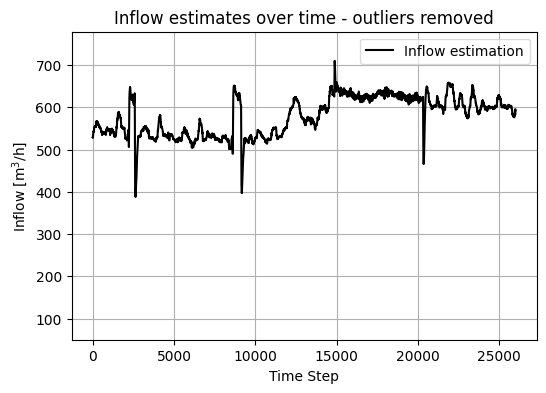

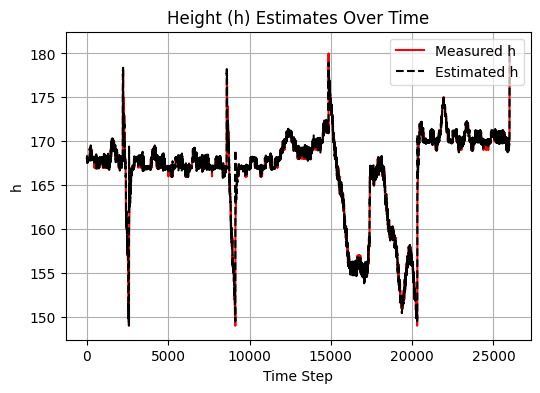

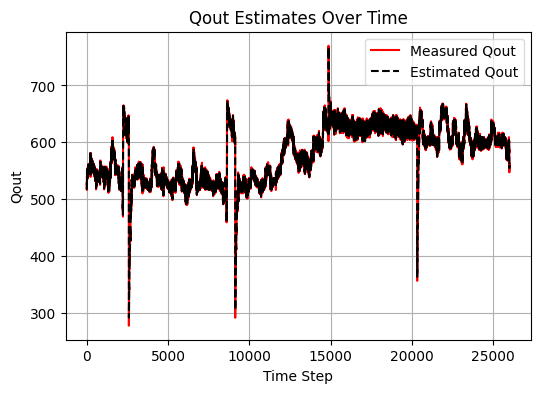

In [29]:
# Assuming your 'estimates' and 'df' are properly defined

# Convert estimates to a numpy array for easier manipulation
estimates = np.array(estimates)

# Time steps for x-axis
time_steps = range(len(estimates))

fig_size = (6, 4)

# Plot for Qin
plt.figure(figsize=fig_size)
plt.plot(time_steps, estimates[:, 0], label='Inflow estimation', color="black", linestyle='-')
plt.xlabel('Time Step')
plt.ylabel('Inflow [m$^3$/h]')
plt.title('Inflow estimates over time - outliers removed')
plt.ylim(50,779)
plt.legend(loc='upper right', fancybox=True, framealpha=0.7)
plt.grid()

plt.show()

# Plot for h
plt.figure(figsize=fig_size)
plt.plot(time_steps, df_filtered["height"], label='Measured h', color="red", linestyle='-')
plt.plot(time_steps, estimates[:, 1], label='Estimated h', color="black", linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('h')
plt.title('Height (h) Estimates Over Time')
plt.legend(loc='upper right', fancybox=True, framealpha=0.7)
plt.grid()

plt.show()

# Plot for Qout
plt.figure(figsize=fig_size)
plt.plot(time_steps, df_filtered["outflow"], label='Measured Qout', color="red", linestyle='-')
plt.plot(time_steps, estimates[:, 2], label='Estimated Qout', color="black", linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Qout')
plt.title('Qout Estimates Over Time')
plt.legend(loc='upper right', fancybox=True, framealpha=0.7)
plt.grid()

plt.show()